This project will attempt to see if we can predict a country's gross national income by creating a model using the leading causes of death by risk factors. One possible benefit of the resulting model could be to see if eliminating or reducing specific risk factors could have the added benefit of improving the GNI of a country's population. Prediction does not necessarily indicate causation, so I will be cautious when interpreting the results.I will be using various data manipulation, statistical analysis, and visualization features from readily available Python libraries. Because this is a cloud based application I also need to install the statistics model each new session

In [1]:
!pip install statsmodels
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  # To visualize
import statsmodels.api as sm


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


The data for GNI comes from the world bank. This is my first data set

In [2]:
df_gni_2019 = pd.read_csv('/work/API_NY.GNP.PCAP.CD_DS2_en_csv_v2_5995153.csv', skiprows=3, 
    usecols=['Country Name', 'Country Code', '2019'])
df_gni_2019=df_gni_2019.rename(columns={'2019' : 'GNI per Capita 2019'})
df_gni_2019

Country Name Country Code  GNI per Capita 2019
0                          Aruba          ABW         30330.000000
1    Africa Eastern and Southern          AFE          1494.589953
2                    Afghanistan          AFG           530.000000
3     Africa Western and Central          AFW          1681.824079
4                         Angola          AGO          2040.000000
..                           ...          ...                  ...
261                       Kosovo          XKX          4640.000000
262                  Yemen, Rep.          YEM                  NaN
263                 South Africa          ZAF          6730.000000
264                       Zambia          ZMB          1390.000000
265                     Zimbabwe          ZWE          1450.000000

[266 rows x 3 columns]

The GNI files contains  data from 1960 to 2019. By selecting just the country, country code, and the year 2019 in the read_csv call I eliminate quite a bit of data not needed for this project. I renamed the GNI column to make it clear it is for 2019 only.

Not every country reports their data every year.

In [3]:
" How many countries do not report their GNI? "
df_gni_2019.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Country Name         266 non-null    object 
 1   Country Code         266 non-null    object 
 2   GNI per Capita 2019  247 non-null    float64
dtypes: float64(1), object(2)
memory usage: 6.4+ KB


All the Country Name and  Country Code values are not null. However 19 GNI numbers are missing.  Although I could estimate the missing country population I will instead remove the data in a later section. I don't want to mix data sources.

The next data set is the number of deaths by risk factor, which comes from "Our World in Data"

In [4]:
"Read in the risk dataset and reduce to just 2019 data."
df_risk = pd.read_csv('/work/number-of-deaths-by-risk-factor.csv')
df_risk_2019 = df_risk[df_risk['Year'] == 2019]
df_risk_2019 = df_risk_2019.drop(columns=['Year'])
df_risk_2019

Entity      Code  \
29                     Afghanistan       AFG   
59            African Region (WHO)       NaN   
89                         Albania       ALB   
119                        Algeria       DZA   
149                 American Samoa       ASM   
...                            ...       ...   
6719  Western Pacific Region (WHO)       NaN   
6749                         World  OWID_WRL   
6779                         Yemen       YEM   
6809                        Zambia       ZMB   
6839                      Zimbabwe       ZWE   

      Deaths that are from all causes attributed to high systolic blood pressure, in both sexes aged all ages  \
29                                         3.601717e+04                                                         
59                                         7.182989e+05                                                         
89                                         7.609211e+03                                                         
119                                        5.860158e+04                                                         
149                                        8.666929e+01                                                         
...                                                 ...                                                         
6719                                       3.252290e+06                                                         
6749                                       1.084560e+07                                                         
6779                                       3.056378e+04                                                         
6809                                       1.034032e+04                                                         
6839                                       1.224099e+04                                                         

      Deaths that are from all causes attributed to diet high in sodium, in both sexes aged all ages  \
29                                         1.421833e+03                                                
59                                         7.173645e+04                                                
89                                         2.444682e+03                                                
119                                        1.909833e+03                                                
149                                        6.474488e+00                                                
...                                                 ...                                                
6719                                       9.872528e+05                                                
6749                                       1.885356e+06                                                
6779                                       1.240843e+03                                                
6809                                       1.827763e+03                                                
6839                                       1.140376e+03                                                

      Deaths that are from all causes attributed to diet low in whole grains, in both sexes aged all ages  \
29                                         1.033487e+04                                                     
59                                         8.823413e+04                                                     
89                                         1.519789e+03                                                     
119                                        1.477198e+04                                                     
149                                        1.569039e+01                                                     
...                                                 ...                                                     
6719                                       4.708269e+05                           

Unlike the GNI data, the risk factors are in long table format. Since I cannot eliminate the unnecessary years by removing columns I instead filter out the unwanted years after reading in the data. I then deleted the year column as all of the remaining data is for the same year.

Now look for missing risk data

In [5]:
df_risk_2019.info()

<class 'pandas.core.frame.DataFrame'>
Index: 228 entries, 29 to 6839
Data columns (total 30 columns):
 #   Column                                                                                                               Non-Null Count  Dtype  
---  ------                                                                                                               --------------  -----  
 0   Entity                                                                                                               228 non-null    object 
 1   Code                                                                                                                 205 non-null    object 
 2   Deaths that are from all causes attributed to high systolic blood pressure, in both sexes aged all ages              228 non-null    float64
 3   Deaths that are from all causes attributed to diet high in sodium, in both sexes aged all ages                       228 non-null    float64
 4   Deaths that are f


Some of the country codes are missing, Upon further investigation, these are not
real countries. They are either regions, or part of larger entities, like Scotland being part of Great Britain

In [6]:
" Dropoing the countries that are not official countries from the dataframe"
df_risk_2019 = df_risk_2019[df_risk_2019['Code'].notna()]
df_risk_2019

Entity      Code  \
29       Afghanistan       AFG   
89           Albania       ALB   
119          Algeria       DZA   
149   American Samoa       ASM   
179          Andorra       AND   
...              ...       ...   
6659         Vietnam       VNM   
6749           World  OWID_WRL   
6779           Yemen       YEM   
6809          Zambia       ZMB   
6839        Zimbabwe       ZWE   

      Deaths that are from all causes attributed to high systolic blood pressure, in both sexes aged all ages  \
29                                         3.601717e+04                                                         
89                                         7.609211e+03                                                         
119                                        5.860158e+04                                                         
149                                        8.666929e+01                                                         
179                                        1.006023e+02                                                         
...                                                 ...                                                         
6659                                       1.583755e+05                                                         
6749                                       1.084560e+07                                                         
6779                                       3.056378e+04                                                         
6809                                       1.034032e+04                                                         
6839                                       1.224099e+04                                                         

      Deaths that are from all causes attributed to diet high in sodium, in both sexes aged all ages  \
29                                         1.421833e+03                                                
89                                         2.444682e+03                                                
119                                        1.909833e+03                                                
149                                        6.474488e+00                                                
179                                        5.914475e+00                                                
...                                                 ...                                                
6659                                       3.215480e+04                                                
6749                                       1.885356e+06                                                
6779                                       1.240843e+03                                                
6809                                       1.827763e+03                                                
6839                                       1.140376e+03                                                

      Deaths that are from all causes attributed to diet low in whole grains, in both sexes aged all ages  \
29                                         1.033487e+04                                                     
89                                         1.519789e+03                                                     
119                                        1.477198e+04                                                     
149                                        1.569039e+01                                                     
179                                        1.919431e+01                                                     
...                                                 ...                                                     
6659                                       1.191471e+04                                                     
6749                                       1.844836e+06                                                     
6779              

Code entries that were nan were filtered out using the .nona method

Time to merge the GNI and risk factor data sets together  

In [7]:
"Merge the GNI and risk 2019 data frames"
df_gni_risk_2019 = pd.merge(df_gni_2019, df_risk_2019,  left_on=['Country Code'], 
    right_on=['Code'], how='inner').sort_values(by=['Country Code'])
df_gni_risk_2019.drop(columns=['Entity', 'Code'],inplace=True)
df_gni_risk_2019

Country Name Country Code  GNI per Capita 2019  \
0             Afghanistan          AFG                530.0   
1                  Angola          AGO               2040.0   
2                 Albania          ALB               5230.0   
3                 Andorra          AND              46530.0   
4    United Arab Emirates          ARE              46210.0   
..                    ...          ...                  ...   
195                 Samoa          WSM               4230.0   
196           Yemen, Rep.          YEM                  NaN   
197          South Africa          ZAF               6730.0   
198                Zambia          ZMB               1390.0   
199              Zimbabwe          ZWE               1450.0   

     Deaths that are from all causes attributed to high systolic blood pressure, in both sexes aged all ages  \
0                                         36017.170000                                                         
1                                         17685.701000                                                         
2                                          7609.211400                                                         
3                                           100.602325                                                         
4                                          5982.615000                                                         
..                                                 ...                                                         
195                                         317.410830                                                         
196                                       30563.783000                                                         
197                                       61472.863000                                                         
198                                       10340.324000                                                         
199                                       12240.987000                                                         

     Deaths that are from all causes attributed to diet high in sodium, in both sexes aged all ages  \
0                                          1421.832900                                                
1                                          1288.708700                                                
2                                          2444.682100                                                
3                                             5.914475                                                
4                                           292.741000                                                
..                                                 ...                                                
195                                          20.181269                                                
196                                        1240.842800                                                
197                                        3290.505000                                                
198                                        1827.762700                                                
199                                        1140.376100                                                

     Deaths that are from all causes attributed to diet low in whole grains, in both sexes aged all ages  \
0                                          10334.86600                                                     
1                                           2012.97470                                                     
2                                           1519.78900                                                     
3                                             19.19431                                                     
4                                           1469.56470                                                     
..                        

The data frames were merged using an inner join, on the value for country code. After the join the duplicate column names were dropped.

There should be 205 entries, but only ended up with 200. That means 5 country names did not match

In [8]:
"Investigate why there are 5 missing entries"
mismatch = df_risk_2019[~df_risk_2019['Code'].isin(df_gni_2019['Country Code'])]
mismatch

Entity      Code  \
1289  Cook Islands       COK   
4349          Niue       NIU   
5999        Taiwan       TWN   
6149       Tokelau       TKL   
6749         World  OWID_WRL   

      Deaths that are from all causes attributed to high systolic blood pressure, in both sexes aged all ages  \
1289                                       4.150273e+01                                                         
4349                                       5.267443e+00                                                         
5999                                       2.569500e+04                                                         
6149                                       2.559496e+00                                                         
6749                                       1.084560e+07                                                         

      Deaths that are from all causes attributed to diet high in sodium, in both sexes aged all ages  \
1289                                       7.032040e+00                                                
4349                                       8.452141e-01                                                
5999                                       5.005322e+03                                                
6149                                       4.343701e-01                                                
6749                                       1.885356e+06                                                

      Deaths that are from all causes attributed to diet low in whole grains, in both sexes aged all ages  \
1289                                       6.028022e+00                                                     
4349                                       9.882727e-01                                                     
5999                                       5.035089e+03                                                     
6149                                       5.177773e-01                                                     
6749                                       1.844836e+06                                                     

      Deaths that are from all causes attributed to alcohol use, in both sexes aged all ages  \
1289                                       7.416185e+00                                        
4349                                       3.799937e-01                                        
5999                                       1.119233e+04                                        
6149                                       1.701279e-01                                        
6749                                       2.441974e+06                                        

      Deaths that are from all causes attributed to diet low in fruits, in both sexes aged all ages  \
1289                                       2.728691e+00                                               
4349                                       5.134809e-01                                               
5999                                       1.416927e+03                                               
6149                                       3.082936e-01                                               
6749                                       1.046015e+06                                               

      Deaths that are from all causes attributed to unsafe water source, in both sexes aged all ages  \
1289                                       3.852834e-01                                                
4349                                       9.070000e-02                                                
5999                                       3.545267e+01                                                
6149                                       7.960739e-02                                                
6749                                       1.230154e+06                                                

      Deaths that are from all causes a

World is clearly not a country. Cook, Niue, and Tokelau are small and apparently did not make
the cut from the world bank. Taiwan's omission is likely a political statement. I could manually add
the data for Taiwan and redo the merge, but since I am going to focus on lower income countries Taiwan would
have been removed anyway, plus I don't want to mix data sources, so I will not bother adding it in.

In [9]:
" Check for missing GNI data"
df_gni_risk_2019['GNI per Capita 2019'].isna().sum()

11

The countries with missing GNI data stopped reporting their data to the World Bank. Inserting GNI data for these countries from another source would mixing data sources. Instead I will drop these countries.

In [10]:
df_gni_risk_2019.dropna(subset=['GNI per Capita 2019'],inplace=True)
df_gni_risk_2019

Country Name Country Code  GNI per Capita 2019  \
0             Afghanistan          AFG                530.0   
1                  Angola          AGO               2040.0   
2                 Albania          ALB               5230.0   
3                 Andorra          AND              46530.0   
4    United Arab Emirates          ARE              46210.0   
..                    ...          ...                  ...   
194               Vanuatu          VUT               3590.0   
195                 Samoa          WSM               4230.0   
197          South Africa          ZAF               6730.0   
198                Zambia          ZMB               1390.0   
199              Zimbabwe          ZWE               1450.0   

     Deaths that are from all causes attributed to high systolic blood pressure, in both sexes aged all ages  \
0                                         36017.170000                                                         
1                                         17685.701000                                                         
2                                          7609.211400                                                         
3                                           100.602325                                                         
4                                          5982.615000                                                         
..                                                 ...                                                         
194                                         596.281500                                                         
195                                         317.410830                                                         
197                                       61472.863000                                                         
198                                       10340.324000                                                         
199                                       12240.987000                                                         

     Deaths that are from all causes attributed to diet high in sodium, in both sexes aged all ages  \
0                                          1421.832900                                                
1                                          1288.708700                                                
2                                          2444.682100                                                
3                                             5.914475                                                
4                                           292.741000                                                
..                                                 ...                                                
194                                          86.356160                                                
195                                          20.181269                                                
197                                        3290.505000                                                
198                                        1827.762700                                                
199                                        1140.376100                                                

     Deaths that are from all causes attributed to diet low in whole grains, in both sexes aged all ages  \
0                                          10334.86600                                                     
1                                           2012.97470                                                     
2                                           1519.78900                                                     
3                                             19.19431                                                     
4                                           1469.56470                                                     
..                        

Used the dropna method to remove rows that had missing GNI data

The third and final data set to read and merge is population data from the world bank. The death numbers are all absolute numbers. The population will be used to calculate the deaths per 100,000 people. 

In [11]:
" Read in World Bank population data and filter to 2019"
df_pop_2019 = pd.read_csv('/work/API_SP.POP.TOTL_DS2_en_csv_v2_6011311.csv', skiprows=3, 
    usecols=['Country Name','Country Code', '2019'])
df_pop_2019=df_pop_2019.rename(columns={'2019' : 'Population 2019'})
df_pop_2019


Country Name Country Code  Population 2019
0                          Aruba          ABW         106442.0
1    Africa Eastern and Southern          AFE      667242986.0
2                    Afghanistan          AFG       37769499.0
3     Africa Western and Central          AFW      454306063.0
4                         Angola          AGO       32353588.0
..                           ...          ...              ...
261                       Kosovo          XKX        1788878.0
262                  Yemen, Rep.          YEM       31546691.0
263                 South Africa          ZAF       58087055.0
264                       Zambia          ZMB       18380477.0
265                     Zimbabwe          ZWE       15354608.0

[266 rows x 3 columns]

Similar to the GNI data set, only read in the 2019 year of data using the usecols parameter of read_csv.

The second and final merge of the GNI and risk data frame with the population data frame

In [12]:
" Merge population data with our risk-GNI data set "
df_gni_risk_pop_2019 = pd.merge(df_gni_risk_2019, df_pop_2019,  
    on=['Country Name','Country Code'], how='inner').sort_values(by=['Country Name'])
df_gni_risk_pop_2019

Country Name Country Code  GNI per Capita 2019  \
0           Afghanistan          AFG                530.0   
2               Albania          ALB               5230.0   
50              Algeria          DZA               4050.0   
3               Andorra          AND              46530.0   
1                Angola          AGO               2040.0   
..                  ...          ...                  ...   
184             Vanuatu          VUT               3590.0   
183            Viet Nam          VNM               3340.0   
142  West Bank and Gaza          PSE               4270.0   
187              Zambia          ZMB               1390.0   
188            Zimbabwe          ZWE               1450.0   

     Deaths that are from all causes attributed to high systolic blood pressure, in both sexes aged all ages  \
0                                         36017.170000                                                         
2                                          7609.211400                                                         
50                                        58601.582000                                                         
3                                           100.602325                                                         
1                                         17685.701000                                                         
..                                                 ...                                                         
184                                         596.281500                                                         
183                                      158375.450000                                                         
142                                        3815.996300                                                         
187                                       10340.324000                                                         
188                                       12240.987000                                                         

     Deaths that are from all causes attributed to diet high in sodium, in both sexes aged all ages  \
0                                          1421.832900                                                
2                                          2444.682100                                                
50                                         1909.833100                                                
3                                             5.914475                                                
1                                          1288.708700                                                
..                                                 ...                                                
184                                          86.356160                                                
183                                       32154.800000                                                
142                                         142.638580                                                
187                                        1827.762700                                                
188                                        1140.376100                                                

     Deaths that are from all causes attributed to diet low in whole grains, in both sexes aged all ages  \
0                                          10334.86600                                                     
2                                           1519.78900                                                     
50                                         14771.98000                                                     
3                                             19.19431                                                     
1                                           2012.97470                                                     
..                                              

I don't want the more prosperous, developed countries to skew the data. I would like to make it easier to see how low GNI countries might transition to medium GNI.  The pivot point can easily be changed. For now I am setting it to the median GNI.

In [13]:
" Filter by GNI "
pivot_gni = df_gni_2019['GNI per Capita 2019'].apply('median')
df_gni_risk_pop_2019_lower = df_gni_risk_pop_2019[df_gni_risk_pop_2019['GNI per Capita 2019'] <= pivot_gni]
df_gni_risk_pop_2019_lower

Country Name Country Code  GNI per Capita 2019  \
0           Afghanistan          AFG                530.0   
2               Albania          ALB               5230.0   
50              Algeria          DZA               4050.0   
1                Angola          AGO               2040.0   
6               Armenia          ARM               4880.0   
..                  ...          ...                  ...   
184             Vanuatu          VUT               3590.0   
183            Viet Nam          VNM               3340.0   
142  West Bank and Gaza          PSE               4270.0   
187              Zambia          ZMB               1390.0   
188            Zimbabwe          ZWE               1450.0   

     Deaths that are from all causes attributed to high systolic blood pressure, in both sexes aged all ages  \
0                                           36017.1700                                                         
2                                            7609.2114                                                         
50                                          58601.5820                                                         
1                                           17685.7010                                                         
6                                            7789.3223                                                         
..                                                 ...                                                         
184                                           596.2815                                                         
183                                        158375.4500                                                         
142                                          3815.9963                                                         
187                                         10340.3240                                                         
188                                         12240.9870                                                         

     Deaths that are from all causes attributed to diet high in sodium, in both sexes aged all ages  \
0                                           1421.83290                                                
2                                           2444.68210                                                
50                                          1909.83310                                                
1                                           1288.70870                                                
6                                           1061.80650                                                
..                                                 ...                                                
184                                           86.35616                                                
183                                        32154.80000                                                
142                                          142.63858                                                
187                                         1827.76270                                                
188                                         1140.37610                                                

     Deaths that are from all causes attributed to diet low in whole grains, in both sexes aged all ages  \
0                                          10334.86600                                                     
2                                           1519.78900                                                     
50                                         14771.98000                                                     
1                                           2012.97470                                                     
6                                           2445.83370                                                     
..                                              

Convert the risk factors to deaths per 100,000. Remove the words in the risk name that are the same for all risks

In [14]:

deathrateper100K = df_gni_risk_pop_2019_lower.iloc[:,0:31]
deathrateper100K.iloc[:,3:31] = deathrateper100K.iloc[:,3:31].div(df_gni_risk_pop_2019_lower.loc[:,'Population 2019'],axis=0)*100000
deathrateper100K.columns = deathrateper100K.columns.str.replace('Deaths that are from all causes attributed to ',"Deaths from ")
deathrateper100K.columns = deathrateper100K.columns.str.replace(', in both sexes aged all ages',"")
deathrateper100K

Country Name Country Code  GNI per Capita 2019  \
0           Afghanistan          AFG                530.0   
2               Albania          ALB               5230.0   
50              Algeria          DZA               4050.0   
1                Angola          AGO               2040.0   
6               Armenia          ARM               4880.0   
..                  ...          ...                  ...   
184             Vanuatu          VUT               3590.0   
183            Viet Nam          VNM               3340.0   
142  West Bank and Gaza          PSE               4270.0   
187              Zambia          ZMB               1390.0   
188            Zimbabwe          ZWE               1450.0   

     Deaths from high systolic blood pressure  \
0                                   95.360465   
2                                  266.597835   
50                                 137.222988   
1                                   54.663801   
6                                  276.158150   
..                                        ...   
184                                195.884910   
183                                165.359032   
142                                 81.446042   
187                                 56.257104   
188                                 79.721911   

     Deaths from diet high in sodium  Deaths from diet low in whole grains  \
0                           3.764500                             27.362995   
2                          85.652365                             53.247628   
50                          4.472115                             34.590452   
1                           3.983202                              6.221797   
6                          37.644677                             86.713180   
..                               ...                                   ...   
184                        28.368931                             33.838281   
183                        33.572669                             12.440090   
142                         3.044381                             25.207976   
187                         9.944044                              4.748298   
188                         7.426931                              9.606680   

     Deaths from alcohol use  Deaths from diet low in fruits  \
0                   1.543651                       12.134087   
2                  25.810177                        7.608351   
50                  3.008927                        6.201714   
1                  36.798939                        4.881277   
6                  28.418969                       11.318605   
..                       ...                             ...   
184                15.012901                       17.517700   
183                55.320673                       15.803480   
142                 4.682947                        7.030915   
187                37.375145                       11.184384   
188                33.578122                       12.764026   

     Deaths from unsafe water source  Deaths from secondhand smoke  ...  \
0                           9.930514                     16.048859  ...   
2                           0.132441                     27.108000  ...   
50                          0.648624                     17.961234  ...   
1                          34.442783                      5.051483  ...   
6                           0.098856                     35.671857  ...   
..                               ...                           ...  ...   
184                        18.351522                     20.873119  ...   
183                         1.305739                     19.926985  ...   
142                         0.456038                     13.132045  ...   
187                        32.181001                      5.000161  ...   
188                        25.491122                     10.719753  ...   

     Deaths from drug use  Deaths from low bone mineral density  \
0              

Divided the deaths in absolute numbers by the population and then multiplied by 100,000. That gives us deaths per 100,000. I shortened the column names to make it easier to fit onto the final report. 

In order to create a first order linear model I will perform a forward selection stepwise linear regression. This means I will create a simple linear model for each variable individually. I will take the model whose variable has  the smallest t-test p-value and put that variable in my model. I will then create two variable models using my first selected variable and add each of the remaining variables. I then pick the second variable from the model with the lowest p-value. This will process continue until the R-squared adjusted value stops increasing or I run out of variables. yhat is the dependent variable, GNI. xvars are all the independent variables. modelVars are the independent variables selected for the model.

In [15]:
modelstats = []
yhat = deathrateper100K['GNI per Capita 2019']
xvars = deathrateper100K.iloc[:,3:32]
midx = 1
modelVars = pd.DataFrame()
max_rsq_adj = 0
best_model = pd.DataFrame()
best_model[['risk']] = ""
best_model[['RsqAdj']] = ""

In [16]:
for i in range(29):
    modelstats = []

    for column in xvars:
        xs=pd.concat([modelVars,xvars[column]],axis=1)

        # Add a constant to the dependent variables first
        xs = sm.add_constant(xs)

        # Build the model
        model = sm.OLS(yhat, xs).fit()

        data = {'risk' : column, 'B0' : model.pvalues[0], 'B1' : model.pvalues[midx],  'RsqAdj' : model.rsquared_adj}

        modelstats.append(data)

    midx += 1
    df_modelstats = pd.DataFrame(modelstats)
    idx = df_modelstats['B1'].idxmin()
    rsq = df_modelstats['RsqAdj'].iloc[idx]

    if rsq > max_rsq_adj :
        modelVars = pd.concat([modelVars,xvars.iloc[:,idx]],axis=1)
        xvars=xvars.drop(xvars.columns[idx],axis=1)
        max_rsq_adj = rsq
        best_model.loc[len(best_model.index)] = df_modelstats.iloc[idx,[0,3]]
    else :
        break
   

best_model

/tmp/ipykernel_301/1578079640.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data = {'risk' : column, 'B0' : model.pvalues[0], 'B1' : model.pvalues[midx],  'RsqAdj' : model.rsquared_adj}
/tmp/ipykernel_301/1578079640.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data = {'risk' : column, 'B0' : model.pvalues[0], 'B1' : model.pvalues[midx],  'RsqAdj' : model.rsquared_adj}
/tmp/ipykernel_301/1578079640.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by

risk    RsqAdj
0                        Deaths from low birth weight  0.450543
1                    Deaths from high body-mass index   0.53805
2   Deaths from household air pollution from solid...  0.589194
3              Deaths from diet low in nuts and seeds  0.628858
4             Deaths from high fasting plasma glucose  0.638178
5                           Deaths from child wasting  0.644272
6       Deaths from no access to handwashing facility   0.65795
7                             Deaths from alcohol use   0.67009
8                      Deaths from diet low in fruits  0.671346
9                  Deaths from diet low in vegetables  0.673737
10                                Deaths from smoking  0.676115
11               Deaths from diet low in whole grains  0.676809

I used nested for loops. The inner loop created a model with every remaining available variable. The outer loop picks the variable with the lowest p-value and adds it to the model. The variable is then removed from the list of remaining variables The outer loop stops when the R squared adjust value stops increasing. The R-squared adjusted value tells us the  proportion of variance in the dependent variable (GNI) that can be explained by the independent variables (risk). The higher the score the better. A score of one means the model perfectly predicts each dependent variable data point.

Our final model is made up of the model variables, modelVars

In [17]:
xs = modelVars

# Add a constant to the dependent variables first
xs = sm.add_constant(xs)

# Build the model
model = sm.OLS(yhat, xs).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     GNI per Capita 2019   R-squared:                       0.717
Model:                             OLS   Adj. R-squared:                  0.677
Method:                  Least Squares   F-statistic:                     17.93
Date:                 Sun, 02 Jun 2024   Prob (F-statistic):           1.66e-18
Time:                         19:26:40   Log-Likelihood:                -812.25
No. Observations:                   98   AIC:                             1651.
Df Residuals:                       85   BIC:                             1684.
Df Model:                           12                                         
Covariance Type:             nonrobust                                         
========================================================================================================================
                                                           coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                 2914.5393    371.561      7.844      0.000    2175.776    3653.303
Deaths from low birth weight                           -10.9583      8.295     -1.321      0.190     -27.451       5.534
Deaths from high body-mass index                         8.3047      7.152      1.161      0.249      -5.915      22.524
Deaths from household air pollution from solid fuels   -25.4300      6.419     -3.962      0.000     -38.193     -12.667
Deaths from diet low in nuts and seeds                 -17.4441     27.080     -0.644      0.521     -71.287      36.399
Deaths from high fasting plasma glucose                  7.9236      4.954      1.599      0.113      -1.927      17.774
Deaths from child wasting                               30.6993      8.825      3.479      0.001      13.153      48.246
Deaths from no access to handwashing facility          -54.5634     20.526     -2.658      0.009     -95.374     -13.753
Deaths from alcohol use                                 11.6200      6.767      1.717      0.090      -1.834      25.074
Deaths from diet low in fruits                         -45.0872     25.797     -1.748      0.084     -96.379       6.204
Deaths from diet low in vegetables                      48.1847     36.039      1.337      0.185     -23.470     119.839
Deaths from smoking                                      6.1638      4.433      1.391      0.168      -2.649      14.977
Deaths from diet low in whole grains                   -15.9180     14.626     -1.088      0.280     -44.998      13.162
==============================================================================
Omnibus:                        2.032   Durbin-Watson:                   1.899
Prob(Omnibus):                  0.362   Jarque-Bera (JB):                1.583
Skew:                           0.070   Prob(JB):                        0.453
Kurtosis:                       3.607   Cond. No.                         627.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The stats model OLS (ordinary simple model) created our model. The summary gives  the individual slope and p-values for each of the predictors. Some of the p-values are higher than we would prefer. We typically look for numbers less than .05, which means a less than 5% chance the slope is not zero (meaningful). However for this project I am looking for the best model prediction which is the model with the highest R squared adjusted score.

Now that we have a model we want to see if the assumptions pertaining to residuals hold true. The residuals measure the difference between predicted values and actual values.One assumption is that the variance of the residuals is constant.   One such test is to plot the residuals versus the fitted model. 

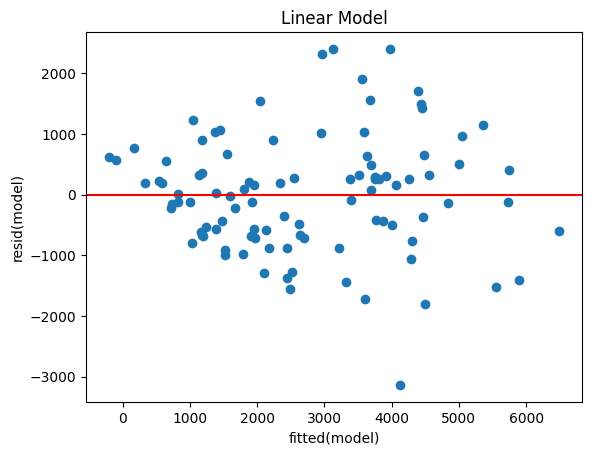

In [18]:
import os
if not os.path.exists( 'GNI-Risk plots' ):
    os.mkdir( 'GNI-Risk plots' )
    
ypred = model.predict(xs)
plt.scatter(ypred, model.resid)
plt.axhline(y = 0.0, color = 'r', linestyle = '-') 
plt.xlabel("fitted(model)")
plt.ylabel("resid(model)")
plt.title("Linear Model")
plt.savefig( os.path.join( 'GNI-Risk plots', 'Fitted-vs-Resid' ) )
plt.show()


The data points fan out in a cone shape. That is not good. It indicates that we might want to try a log-linear model.

In [19]:
# Build the model
modelog = sm.OLS(np.log(yhat), xs).fit()
modelog.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     GNI per Capita 2019   R-squared:                       0.708
Model:                             OLS   Adj. R-squared:                  0.666
Method:                  Least Squares   F-statistic:                     17.15
Date:                 Sun, 02 Jun 2024   Prob (F-statistic):           5.99e-18
Time:                         19:26:40   Log-Likelihood:                -58.508
No. Observations:                   98   AIC:                             143.0
Df Residuals:                       85   BIC:                             176.6
Df Model:                           12                                         
Covariance Type:             nonrobust                                         
========================================================================================================================
                                                           coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
const                                                    7.8555      0.170     46.282      0.000       7.518       8.193
Deaths from low birth weight                            -0.0036      0.004     -0.953      0.343      -0.011       0.004
Deaths from high body-mass index                         0.0029      0.003      0.883      0.379      -0.004       0.009
Deaths from household air pollution from solid fuels    -0.0110      0.003     -3.739      0.000      -0.017      -0.005
Deaths from diet low in nuts and seeds                  -0.0066      0.012     -0.535      0.594      -0.031       0.018
Deaths from high fasting plasma glucose                  0.0025      0.002      1.119      0.266      -0.002       0.007
Deaths from child wasting                                0.0107      0.004      2.661      0.009       0.003       0.019
Deaths from no access to handwashing facility           -0.0265      0.009     -2.827      0.006      -0.045      -0.008
Deaths from alcohol use                                  0.0029      0.003      0.934      0.353      -0.003       0.009
Deaths from diet low in fruits                          -0.0093      0.012     -0.793      0.430      -0.033       0.014
Deaths from diet low in vegetables                       0.0216      0.016      1.311      0.193      -0.011       0.054
Deaths from smoking                                      0.0029      0.002      1.426      0.157      -0.001       0.007
Deaths from diet low in whole grains                    -0.0084      0.007     -1.257      0.212      -0.022       0.005
==============================================================================
Omnibus:                        7.060   Durbin-Watson:                   1.827
Prob(Omnibus):                  0.029   Jarque-Bera (JB):                6.511
Skew:                          -0.580   Prob(JB):                       0.0386
Kurtosis:                       3.501   Cond. No.                         627.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

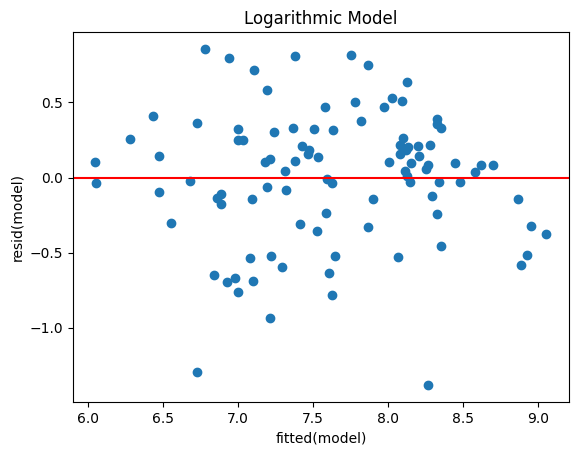

In [20]:
ypred = modelog.predict(xs)
plt.scatter(ypred, modelog.resid)
plt.axhline(y = 0.0, color = 'r', linestyle = '-') 
plt.xlabel("fitted(model)")
plt.ylabel("resid(model)")
plt.title("Logarithmic Model")
plt.savefig( os.path.join( 'GNI-Risk plots', 'Fitted-log-vs-Resid' ) )
plt.show()




Although the variance is slightly less flared out I don't think the improvement is sufficient to change to a log model. A log-linear model means that the terms become multiplicative. The exponent of the model Beta values become the coefficients in the multiplicative model. Changes in the independent variables become percent changes in the dependent variable. Since I am not convinced that this is the case I will keep the linear model for now.

A QQ plot plots the residual quantiles versus a theoretical normal distribution quantiles. The ideal result is a straight diagonal line.

In [21]:
sm.qqplot(model.resid)
plt.savefig( os.path.join( 'GNI-Risk plots', 'QQPlot' ) )

Our QQ plot is quite straight except at the extreme tails. The plot indicates skew to the left

The histogram of residuals will tell us if the residuals are distributed around zero

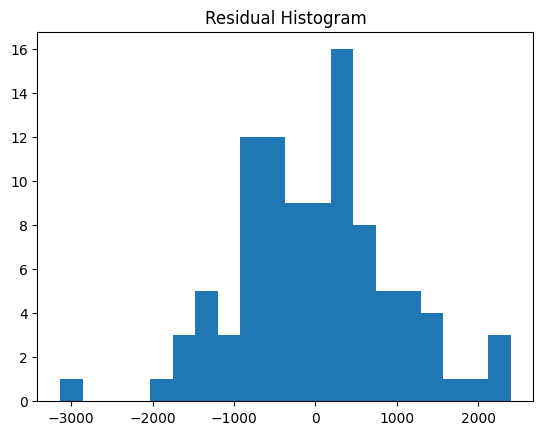

In [22]:

plt.hist(model.resid, bins=20)
plt.title('Residual Histogram')
plt.savefig( os.path.join( 'GNI-Risk plots', 'Resid Histogram' ) )

The histogram is centered around zero. The peaks are to the left and right but appear to be within one standard deviation

The last test is called Cook's Distance. It is a measure of outliers and influencers among the sample data points.

In [23]:
sm.graphics.influence_plot(model, external=True, alpha = 0.05)
plt.savefig( os.path.join( 'GNI-Risk plots', 'Cooks D' ) )
plt.show()

There are two high leverage points and one high influencer. The numbers next to the bubbles tell you the index for the country. 20 is the index for Bellarus, 106 is Moldavo, 164 is Syrian Arab Republic. Looking at the modelVars, Moldavo is in the top 4 for many categories, confirming that is has high leverage.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=afeacf8c-bdd6-4dc6-a7d0-d44661b39e0f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>